In [6]:
import os
from datasets import load_dataset
from PIL import Image
import pandas as pd
import torch

In [7]:
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

In [8]:
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.max_rows', None)     # Show all rows
pd.set_option('display.max_colwidth', None) # Show full content of each column (no truncation)
pd.set_option('display.width', None)

In [9]:
dataset = load_dataset("ahmedheakl/arocrbench_hindawi",split="train")

In [10]:
dataset

Dataset({
    features: ['image', 'text', 'source'],
    num_rows: 200
})

In [11]:
results = []
for sample in dataset:
    image = sample["image"]  # Already a PIL Image object
    if image.mode != "RGB":
        image = image.convert("RGB")
    ground_truth = sample["text"]
    results.append({
        "image": image,
        "ground_truth": ground_truth,
        "qari": None,
        
    })
print(f"Initialized results with {len(results)} samples.")

Initialized results with 200 samples.


## Qwenvl2.5 3B 

In [12]:
import torch 
torch.cuda.empty_cache()

In [13]:
from transformers import AutoProcessor, AutoModelForImageTextToText

processor = AutoProcessor.from_pretrained("NAMAA-Space/Qari-OCR-0.1-VL-2B-Instruct",use_fast=True)

model = AutoModelForImageTextToText.from_pretrained("NAMAA-Space/Qari-OCR-0.1-VL-2B-Instruct",torch_dtype="auto",device_map="cuda:1")

In [14]:
from PIL import Image 
import requests

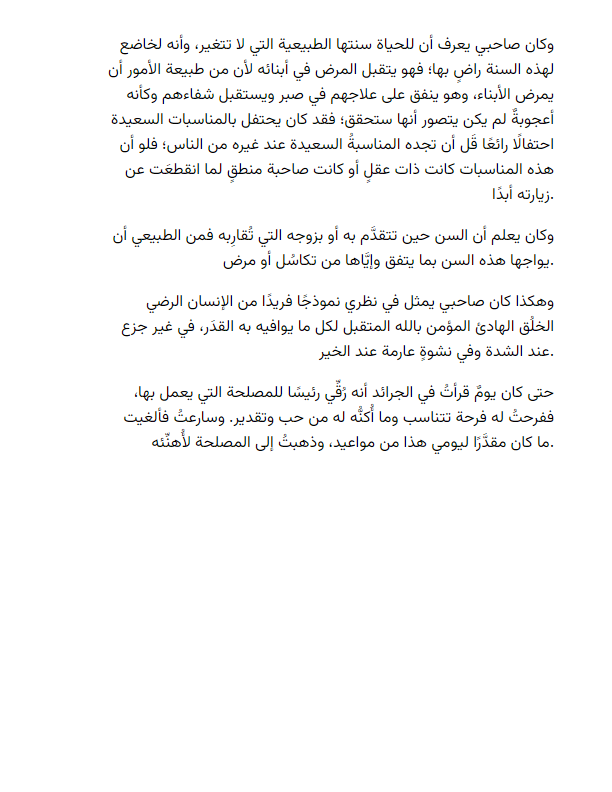

In [15]:
image = dataset[2]['image']
image

In [16]:
# dataset[2]['answer']

In [17]:
messages = [
    {
        "role": "user",
        "content": [
            {
                "type": "image",
            },
            {
                "type": "text",
                "text": "Below is the image of one page of a document, as well as some raw textual content that was previously extracted for it. Just return the plain text representation of this document as if you were reading it naturally. Do not hallucinate"
            }
        ]
    }
]

text_prompt = processor.apply_chat_template(messages, add_generation_prompt=True)



In [19]:
def qwen_extract_ocr(text_prompt,image):
    
    inputs = processor(
        text = [text_prompt],
        images = [image],
        padding = True,
        return_tensors = "pt"
    )

    inputs = inputs.to("cuda:1")

    output_ids = model.generate(**inputs, max_new_tokens=1024)

    generated_ids = [
        output_ids[len(input_ids) :]
        for input_ids, output_ids in zip(inputs.input_ids, output_ids)
    ]

    output_text = processor.batch_decode(
        generated_ids, skip_special_tokens=True, clean_up_tokenization_spaces=True
    )
    return output_text


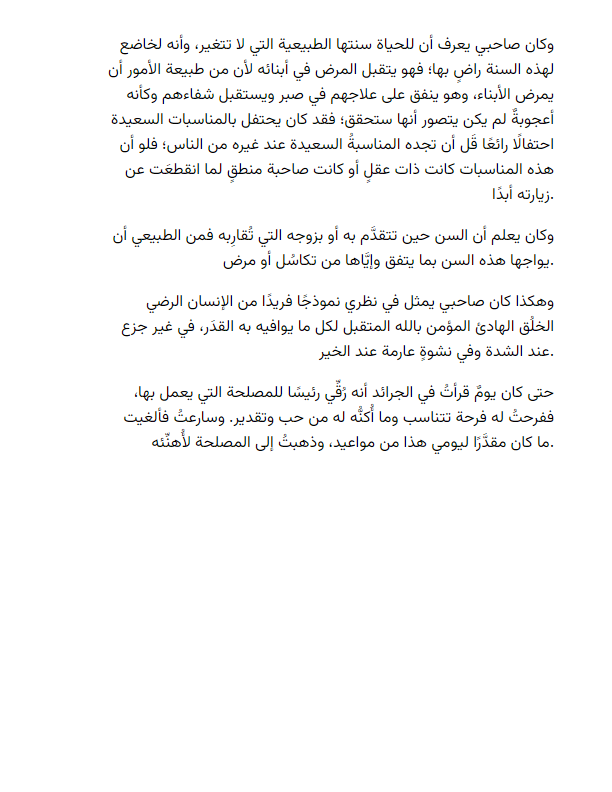

In [20]:
image = dataset[2]['image']
image

In [21]:
qwen_extract_ocr(text_prompt,image=dataset[2]['image'])


['وكان صاحبي يعرف أن للحياة سنتها الطبيعية التي لا تتغير، وأنه لخاضع لهذه السنة راض بها؛ فهو يتقبل المرض في أبنائه لأن من طبيعة الأمور أن يمرض الأبناء، وهو يتفق على علاجهم في صبر ويستقبل شفاءهم وكأنه أجوبيةً لم يكن يتصور أنها ستححق؛ فقد كان يحتفل بالمناسبات السعيدة احتفالًا رائعًا قلَ أن تجده المناسبةً السعيدة عند غيره من الناس؛ فلو أن هذه المناسبات كانت ذات عقلٍ أو كانت صاحبة منطقٍ لما انقطعت عن زيارته أبدًا.\nوكان يعلم أن السن حين تتقدّم به أو يزوجه التي تُقاربه فمن الطبيعي أن يواجهها هذه السن بما يتفق وإيّاها من نكاشلٍ أو مرض.\nوهكذا كان صاحبي يمثل في نظري نموذجًا فريدًا من الإنسان الرضي الخلّق الهادئ المؤمن بالله المتقبل لكل ما يوافيه به القدر، في غير جزع عند الشدة وفي نشوةٍ عارمة عند الخير.\nحتى كان يومٌ قرآتُ في الجرائد أنه رَقِيْ رئيسا للمصلحة التي يعمل بها، ففرحتُ له فرحة تتناسب وما أُكْثَّه له من حب وتقدير. وسارعتُ فألغيت.\nما كان مقدّرًا ليومي هذا من مواعيد، وذهبتُ إلى المصلحة لأُهْنَّته. ']

In [23]:

for i, sample in enumerate(results):
    torch.cuda.empty_cache()
    image = sample['image']
    text_result = " ".join(qwen_extract_ocr(text_prompt,image=image)).replace("The Arabic text in the image is:\n\n","")
    print(text_result)
    print("*****"*40)
    results[i]['qari'] = text_result

وأمَّسَوْ مِثلًا آدمَ وأَعِيْرًا، إِنْنَتَتْفَ الرَّأْيِ المَوَهِومَ، سَبِينَ نَتَتَتْفَ العِبارات فِي لِفَظِها، سَبِئَ إِذَا مَا أَمْعَنَتِ النَّظَرِ فِي مُحَدِّولِها، أَلْفَيْتِها تَستَوِيْدُ مُحَدِّقاَوَ لِمَحَّنَا، وَالمَثلِ الحَبِّيِ أَسْوَقَهُ وَوَنَتَتَتْفَ القَاثِينَ بالفَرْصِحِيَةِ وَالِيِمِتَمَسَمِيَةِ فِيْ خَلْنِيْ أَنَّهُ لَوْ تَرَبَّدَ التَّقَابِل بين الحَطَرِينِ وَمُحَدِّدَ مُحَطَّلَاً مِنَ الْقَيَوْدِ، لَّاَفْرَ عَنْتَاً مِنَ مَعْنَا، فَالْمَعْنَعُ الْقَيْقَنِ المُقْحَوْمَ وَوَوَأَيْنَشَطَ الفَرْودَ فِي مِيَادِينِ الحَمْلِ وَالفَحْصَرْ إِلَّا بِمَا مِسَالَةً أَنْ تَحْدِمُ المُجْمَعَ، لَحْنَ مِضَا نَفْسَةً لِإِنْتَفِيْ أَنَّي بِيْنَوُنَ الفَرْودَ فِيْ نَشَاطِلَةٍ فَرْحَّا، وَإِنْماَ وَوَمُطَالِب بِنْوَع مَعْبِين من النَّشَاطِلَةِ الحَبِّيِ سَقَقَ بِهِ فَرْدْيْنَةٍ وَالْخَبْدِ يَغْيِدُ المُجْمَعَ فِي الْوَقَتِ نَفْسَةً، إِذَا قَدَ بَنَشَطَ الفَرْودَ بِمَا يَمْحَدُ مُمَجْمَعَ، وَإِذْنَ فَلِيسُ الشَرَحَطَ وَوَأَيْنَشَطَ الفَرْودَ مِن سَبِيثِ وَوَفَرْدَ، بِل الشَرَحَطَ وَأَنَ

In [24]:
import re

def remove_diacritics(text):
    diacritics = [
        '\u0617', '\u0618', '\u0619', '\u061A',  # Small high signs
        '\u064B', '\u064C', '\u064D', '\u064E', '\u064F', '\u0650',  # Tanween and basic diacritics
        '\u0651', '\u0652', '\u0653', '\u0654', '\u0655', '\u0656',  # Shadda, sukun, etc.
        '\u0657', '\u0658', '\u0659', '\u065A', '\u065B', '\u065C', 
        '\u065D', '\u065E', '\u065F', '\u0670'   # Additional Arabic diacritics
    ]
    pattern = '[' + ''.join(diacritics) + ']'
    return re.sub(pattern, '', text)
def remove_english_letters(text):
    # Regex pattern to match English letters (a-z and A-Z)
    pattern = r'[a-zA-Z]'
    # Replace English letters with an empty string
    cleaned_text = re.sub(pattern, '', text)
    return cleaned_text

In [42]:
def clean_text(text):
    # Replace all tabs and multiple newlines with a single space
    cleaned = re.sub(r'[\n\t]+', ' ', text)
    # Replace multiple spaces with a single space
    cleaned = re.sub(r'\s+', ' ', cleaned)
    # Strip leading/trailing whitespace
    cleaned = cleaned.strip()
    return cleaned

In [43]:
df = pd.DataFrame(results)
df.head()

,image,ground_truth,qari
0,<PIL.Image.Image image mode=RGB size=612x792 at 0x7E0BBE222410>,\t\t\tوأسوق مثلًا آخر وأخيرًا، لاختلاف الرأي الموهوم، حين تختلف العبارات في لفظها، حتى إذا\tما أمعنت النظر في مدلولاتها، ألفيتها تستهدف هدفًا واحدًا، والمثل الذي أسوقه هو اختلاف\tالقائلين بالفردية والاجتماعية، ففي ظني أنه لو ترك التقابل بين الطرفين هكذا مطلقًا من\tالقيود، لأفرغناه من معناه، فالمعنى الحقيقي المقصود هو ألا ينشط الفرد في ميادين العمل\tوالفكر إلَّا بما عساه أن يخدم المجموع، لكن هذا نفسه لا ينفي أن يكون الفرد في نشاطه فردًا،\tوإنما هو مطالب بنوع معين من النشاط الذي يحقق به فرديته والذي يفيد المجتمع في الوقت نفسه،\tإذ قد ينشط الفرد بما يهدم المجتمع، وإذن فليس الشرط هو ألا ينشط الفرد من حيث هو فرد، بل\tالشرط هو أن يوجه نشاطه الفردي نحو خدمة الناس، افرض أن الفرد الذي نخاطبه بهذا الكلام\tيحترف مهنة الحكم في لعبة الكرة، فكيف يمكن أن يمارس حرفته إلا من حيث هو فرد؟ لهذا فنحن لا\tنطالبه بأن يحد من فرديته، بل نطالبه بأن يوجه نشاطه الفردي في أدائه لحرفته نحو هدف معين,وأمَّسَوْ مِثلًا آدمَ وأَعِيْرًا، إِنْنَتَتْفَ الرَّأْيِ المَوَهِومَ، سَبِينَ نَتَتَتْفَ العِبارات فِي لِفَظِها، سَبِئَ إِذَا مَا أَمْعَنَتِ النَّظَرِ فِي مُحَدِّولِها، أَلْفَيْتِها تَستَوِيْدُ مُحَدِّقاَوَ لِمَحَّنَا، وَالمَثلِ الحَبِّيِ أَسْوَقَهُ وَوَنَتَتَتْفَ القَاثِينَ بالفَرْصِحِيَةِ وَالِيِمِتَمَسَمِيَةِ فِيْ خَلْنِيْ أَنَّهُ لَوْ تَرَبَّدَ التَّقَابِل بين الحَطَرِينِ وَمُحَدِّدَ مُحَطَّلَاً مِنَ الْقَيَوْدِ، لَّاَفْرَ عَنْتَاً مِنَ مَعْنَا، فَالْمَعْنَعُ الْقَيْقَنِ المُقْحَوْمَ وَوَوَأَيْنَشَطَ الفَرْودَ فِي مِيَادِينِ الحَمْلِ وَالفَحْصَرْ إِلَّا بِمَا مِسَالَةً أَنْ تَحْدِمُ المُجْمَعَ، لَحْنَ مِضَا نَفْسَةً لِإِنْتَفِيْ أَنَّي بِيْنَوُنَ الفَرْودَ فِيْ نَشَاطِلَةٍ فَرْحَّا، وَإِنْماَ وَوَمُطَالِب بِنْوَع مَعْبِين من النَّشَاطِلَةِ الحَبِّيِ سَقَقَ بِهِ فَرْدْيْنَةٍ وَالْخَبْدِ يَغْيِدُ المُجْمَعَ فِي الْوَقَتِ نَفْسَةً، إِذَا قَدَ بَنَشَطَ الفَرْودَ بِمَا يَمْحَدُ مُمَجْمَعَ، وَإِذْنَ فَلِيسُ الشَرَحَطَ وَوَأَيْنَشَطَ الفَرْودَ مِن سَبِيثِ وَوَفَرْدَ، بِل الشَرَحَطَ وَأَنَ بِوْجِبَةٍ نَشَاطِلَةٍ الفَرْودِ فِيْ نِمْ سَحَدَمَةَ التَّانَسَ، لَافْرُضُ أَنَ الفَرْودِ الحَبِّيِ غَناَطِلِيَةِ بِمَحْضَا الحَّمْلِ لَسْتَرَفَ مَهْنَةٍ الْمُجْمَعَ فِي لِعِبْلةِ الحَّمْلِ، فَحْيَفِ يَمْحَنَّنَ أَنَ يَمَارَسُ سَرْفَتْهُ إِلَّا مِن سَبِيثِ وَوَفَرْدَ ؟ لَ
1,<PIL.Image.Image image mode=RGB size=612x792 at 0x7E0BBE51DD10>,\n\t\t\tنحن تعودنا تقسيم الكلام إلى منظوم ومنثور، وعندما نقرأ نثر عبد الحميد ونثر ابن\n\tالمقفع تُلهمنا هذه القراءة فكرة جديدة، فتقسيم الكلام إلى منثور ومنظوم لا يغني كثيرًا\n\tمن الناحية الأدبية.\n\t\t\t\t\n\t\t\tذلك أننا، عندما نقرأ عبد الحميد وابن المقفع، نجد في أنفسنا من اللذة مثل ما نجده\n\tعندما نقرأ زيادًا والحجاج وجريرًا والفرزدق والأخطل.\n\t\t\t\t\n\t\t\tومع ذلك فنحن عندما نقرأ عبد الحميد لا نسمعه ولا نراه، ولا نكوِّن لأنفسنا فكرة عنه،\n\tوإنما نفكر في شيء واحد، هو هذا الكلام الذي عندنا، ولا نسمع أنفسنا، بل يقرأ القارئ\n\tبعينه، وقلما يقرأ القارئ بصوته، وخصوصًا في هذا العصر.\n\t\t\t\t\n\t\t\tونحن عندما نقرأ عبد الحميد أو ابن المقفع، لا نجد عندهما اللذة الفنية، إذا كنا في\n\tطبقة واحدة، أو اشتركنا في ثقافة واحدة.\n\t\t\t\t\n\t\t\tوإنما يقرؤهما منا ذوو الثقافة العالية والساذجة والمتوسطة والبسيطة، وكلنا يجد لذة\n\tومتعة فنية.\n\t\t\t\t,نحن تعوددا تقسيم الكلام إلى منظوم ومثثور، وعندما نقرأ ثثر عبد الحميد ودثر ابن المقفع نُلْيهمدا هذه القراءة فكرة جديدة، فتقسيم الكلام إلى مثثور ومظوم لا يغنى كثيرًا من الناحية الإبدية. \nإذاً، عندما نقرأ عبد الحميد وابن المقفع، نجد في أنفسدا من اللّذة مثل ما نجده عندما نقرأ زيداً والحجاج وجزيراً والفرردق والأخطل. \nومع ذلك فنحن عندما نقرأ عبد الحميد لا نسمعه ولا دراء، ولا دكُون لأنفسدا فكرة عنه، وإِمَا تفكر في شيء واحد، هو هذا الكلام الذي عدنا، ولا نسمع أنفسدا، بل نقرأ القارئ بعينه، وقلما نقرأ القارئ بصدوته، وخصوصاً في هذا العصر. \nونحن عندما نقرأ عبد الحميد أو ابن المقفع، لا نجد عدنهما اللّذة الفنية، إذا كنا في طيفة واحدة، أو اشتركنا في ثقافة واحدة. \nوإِمَا يقرأهما مداً ذوَّر الثقافة العالية والسائجة والمتوسطة والبسيطة، وكلنا يجد لذة ومتعة فنية
2,<PIL.Image.Image image mode=RGB size=612x792 at 0x7E0BBE221CD0>,\n\t\t\tوك

In [44]:
df['ground_truth'] = df['ground_truth'].apply(remove_english_letters).apply(clean_text)
df['qari'] = df['qari'].apply(remove_english_letters).apply(clean_text)

In [45]:

df['ground_truth_t'] = df["ground_truth"].apply(remove_diacritics)
df['qari_t'] = df["qari"].apply(remove_diacritics)


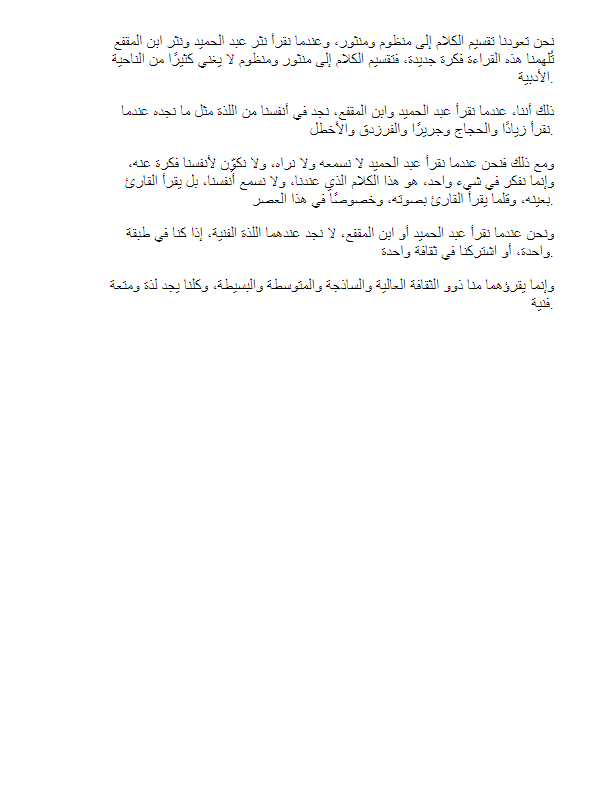

In [46]:
df.iloc[1]['image']

In [47]:
print(df.iloc[1]["qari"])
print('\n')
print(df.iloc[1]["ground_truth"])

نحن تعوددا تقسيم الكلام إلى منظوم ومثثور، وعندما نقرأ ثثر عبد الحميد ودثر ابن المقفع نُلْيهمدا هذه القراءة فكرة جديدة، فتقسيم الكلام إلى مثثور ومظوم لا يغنى كثيرًا من الناحية الإبدية. إذاً، عندما نقرأ عبد الحميد وابن المقفع، نجد في أنفسدا من اللّذة مثل ما نجده عندما نقرأ زيداً والحجاج وجزيراً والفرردق والأخطل. ومع ذلك فنحن عندما نقرأ عبد الحميد لا نسمعه ولا دراء، ولا دكُون لأنفسدا فكرة عنه، وإِمَا تفكر في شيء واحد، هو هذا الكلام الذي عدنا، ولا نسمع أنفسدا، بل نقرأ القارئ بعينه، وقلما نقرأ القارئ بصدوته، وخصوصاً في هذا العصر. ونحن عندما نقرأ عبد الحميد أو ابن المقفع، لا نجد عدنهما اللّذة الفنية، إذا كنا في طيفة واحدة، أو اشتركنا في ثقافة واحدة. وإِمَا يقرأهما مداً ذوَّر الثقافة العالية والسائجة والمتوسطة والبسيطة، وكلنا يجد لذة ومتعة فنية


نحن تعودنا تقسيم الكلام إلى منظوم ومنثور، وعندما نقرأ نثر عبد الحميد ونثر ابن المقفع تُلهمنا هذه القراءة فكرة جديدة، فتقسيم الكلام إلى منثور ومنظوم لا يغني كثيرًا من الناحية الأدبية. ذلك أننا، عندما نقرأ عبد الحميد وابن المقفع، نجد في أنفسنا من اللذة

In [48]:
df.head()

,image,ground_truth,qari,ground_truth_t,qari_t
0,<PIL.Image.Image image mode=RGB size=612x792 at 0x7E0BBE222410>,وأسوق مثلًا آخر وأخيرًا، لاختلاف الرأي الموهوم، حين تختلف العبارات في لفظها، حتى إذا ما أمعنت النظر في مدلولاتها، ألفيتها تستهدف هدفًا واحدًا، والمثل الذي أسوقه هو اختلاف القائلين بالفردية والاجتماعية، ففي ظني أنه لو ترك التقابل بين الطرفين هكذا مطلقًا من القيود، لأفرغناه من معناه، فالمعنى الحقيقي المقصود هو ألا ينشط الفرد في ميادين العمل والفكر إلَّا بما عساه أن يخدم المجموع، لكن هذا نفسه لا ينفي أن يكون الفرد في نشاطه فردًا، وإنما هو مطالب بنوع معين من النشاط الذي يحقق به فرديته والذي يفيد المجتمع في الوقت نفسه، إذ قد ينشط الفرد بما يهدم المجتمع، وإذن فليس الشرط هو ألا ينشط الفرد من حيث هو فرد، بل الشرط هو أن يوجه نشاطه الفردي نحو خدمة الناس، افرض أن الفرد الذي نخاطبه بهذا الكلام يحترف مهنة الحكم في لعبة الكرة، فكيف يمكن أن يمارس حرفته إلا من حيث هو فرد؟ لهذا فنحن لا نطالبه بأن يحد من فرديته، بل نطالبه بأن يوجه نشاطه الفردي في أدائه لحرفته نحو هدف معين,وأمَّسَوْ مِثلًا آدمَ وأَعِيْرًا، إِنْنَتَتْفَ الرَّأْيِ المَوَهِومَ، سَبِينَ نَتَتَتْفَ العِبارات فِي لِفَظِها، سَبِئَ إِذَا مَا أَمْعَنَتِ النَّظَرِ فِي مُحَدِّولِها، أَلْفَيْتِها تَستَوِيْدُ مُحَدِّقاَوَ لِمَحَّنَا، وَالمَثلِ الحَبِّيِ أَسْوَقَهُ وَوَنَتَتَتْفَ القَاثِينَ بالفَرْصِحِيَةِ وَالِيِمِتَمَسَمِيَةِ فِيْ خَلْنِيْ أَنَّهُ لَوْ تَرَبَّدَ التَّقَابِل بين الحَطَرِينِ وَمُحَدِّدَ مُحَطَّلَاً مِنَ الْقَيَوْدِ، لَّاَفْرَ عَنْتَاً مِنَ مَعْنَا، فَالْمَعْنَعُ الْقَيْقَنِ المُقْحَوْمَ وَوَوَأَيْنَشَطَ الفَرْودَ فِي مِيَادِينِ الحَمْلِ وَالفَحْصَرْ إِلَّا بِمَا مِسَالَةً أَنْ تَحْدِمُ المُجْمَعَ، لَحْنَ مِضَا نَفْسَةً لِإِنْتَفِيْ أَنَّي بِيْنَوُنَ الفَرْودَ فِيْ نَشَاطِلَةٍ فَرْحَّا، وَإِنْماَ وَوَمُطَالِب بِنْوَع مَعْبِين من النَّشَاطِلَةِ الحَبِّيِ سَقَقَ بِهِ فَرْدْيْنَةٍ وَالْخَبْدِ يَغْيِدُ المُجْمَعَ فِي الْوَقَتِ نَفْسَةً، إِذَا قَدَ بَنَشَطَ الفَرْودَ بِمَا يَمْحَدُ مُمَجْمَعَ، وَإِذْنَ فَلِيسُ الشَرَحَطَ وَوَأَيْنَشَطَ الفَرْودَ مِن سَبِيثِ وَوَفَرْدَ، بِل الشَرَحَطَ وَأَنَ بِوْجِبَةٍ نَشَاطِلَةٍ الفَرْودِ فِيْ نِمْ سَحَدَمَةَ التَّانَسَ، لَافْرُضُ أَنَ الفَرْودِ الحَبِّيِ غَناَطِلِيَةِ بِمَحْضَا الحَّمْلِ لَسْتَرَفَ مَهْنَةٍ الْمُجْمَعَ فِي لِعِبْلةِ الحَّمْلِ، فَحْيَفِ يَمْحَنَّنَ أَنَ يَمَارَسُ سَرْفَتْهُ إِلَّا مِن سَبِيثِ وَوَفَرْدَ ؟ لَ,وأسوق مثلا آخر وأخيرا، لاختلاف الرأي الموهوم، حين تختلف العبارات في لفظها، حتى إذا ما أمعنت النظر في مدلولاتها، ألفيتها تستهدف هدفا واحدا، والمثل الذي أسوقه هو اختلاف القائلين بالفردية والاجتماعية، ففي ظني أنه لو ترك التقابل بين الطرفين هكذا مطلقا من القيود، لأفرغناه من معناه، فالمعنى الحقيقي المقصود هو ألا ينشط الفرد في ميادين العمل والفكر إلا بما عساه أن يخدم المجموع، لكن هذا نفسه لا ينفي أن يكون الفرد في نشاطه فردا، وإنما هو مطالب بنوع معين من النشاط الذي يحقق به فرديته والذي يفيد المجتمع في الوقت نفسه، إذ قد ينشط الفرد بما يهدم المجتمع، وإذن فليس الشرط هو ألا ينشط الفرد من حيث هو فرد، بل الشرط هو أن يوجه نشاطه الفردي نحو خدمة الناس، افرض أن الفرد الذي نخاطبه بهذا الكلام يحترف مهنة الحكم في لعبة الكرة، فكيف يمكن أن يمارس حرفته إلا من حيث هو فرد؟ لهذا فنحن لا نطالبه بأن يحد من فرديته، بل نطالبه بأن يوجه نشاطه الفردي في أدائه لحرفته نحو هدف معين,وأمسو مثلا آدم وأعيرا، إننتتف الرأي الموهوم، سبين نتتتف العبارات في لفظها، سبئ إذا ما أمعنت النظر في محدولها، ألفيتها تستويد محدقاو لمحنا، والمثل الحبي أسوقه وونتتتف القاثين بالفرصحية واليمتمسمية في خلني أنه لو تربد التقابل بين الحطرين ومحدد محطلا من القيود، لافر عنتا من معنا، فالمعنع القيقن المقحوم وووأينشط الفرود في ميادين الحمل والفحصر إلا بما مسالة أن تحدم المجمع، لحن مضا نفسة لإنتفي أني بينون الفرود في نشاطلة فرحا، وإنما وومطالب بنوع معبين من النشاطلة الحبي سقق به فردينة والخبد يغيد المجمع في الوقت نفسة، إذا قد بنشط الفرود بما يمحد ممجمع، وإذن فليس الشرحط ووأينشط الفرود من سبيث ووفرد، بل الشرحط وأن بوجبة نشاطلة الفرود في نم سحدمة التانس، لافرض أن الفرود الحبي غناطلية بمحضا الحمل لسترف مهنة المجمع في لعبلة الحمل، فحيف يمحنن أن يمارس سرفته إلا من سبيث ووفرد ؟ ل
1,<PIL.Image.Image image mode=RGB size=612x792 at 0x7E0BBE51DD10>,نحن تعودنا تقسيم الكلام إلى منظوم ومنثور، وعن

In [49]:
from jiwer import wer, cer 

# for model in ["tesseract","easyocr"]:
for model in ["qari"]:
    wer_score = wer(df["ground_truth"].tolist(), df[model].tolist())
    cer_score = cer(df["ground_truth"].tolist(), df[model].tolist())
    print(f"{model} - WER: {wer_score:.2f}, CER: {cer_score:.2f}")

qari - WER: 0.49, CER: 0.32


In [50]:
from jiwer import wer, cer 

# for model in ["tesseract","easyocr"]:
for model in ["qari_t"]:
    wer_score = wer(df["ground_truth_t"].tolist(), df[model].tolist())
    cer_score = cer(df["ground_truth_t"].tolist(), df[model].tolist())
    print(f"{model} - WER: {wer_score:.2f}, CER: {cer_score:.2f}")

qari_t - WER: 0.42, CER: 0.23


In [51]:
df.to_csv("khattat_dl_hindawi_namma_result.csv")

: 